In [1]:
import numpy as np
import networkx as nx
from scipy.stats import norm

class NonlinearPolymer:
    def __init__(self, num_nodes, coupling_constants):
        self.graph = nx.Graph()
        self.num_nodes = num_nodes
        
        # Ensure coupling_constants is an array of length num_nodes
        if len(coupling_constants) != num_nodes:
            raise ValueError("Length of coupling_constants must match num_nodes.")
        
        self.coupling_constants = coupling_constants
        self.positions = np.random.rand(num_nodes)  # Initialize node positions
        self.create_polymer()
        self.update_probabilities()

    def create_polymer(self):
        for i in range(self.num_nodes):
            self.graph.add_node(i)
        
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                # Use a coupling constant from the array to determine edge probability
                coupling_constant_ij = (self.coupling_constants[i] + self.coupling_constants[j]) / 2
                if np.random.rand() < coupling_constant_ij:
                    self.graph.add_edge(i, j)

    def update_probabilities(self):
        degrees = np.array([self.graph.degree(n) for n in self.graph.nodes()])
        weighted_degrees = degrees ** self.coupling_constants
        total_weighted_degree = np.sum(weighted_degrees)
        self.probabilities = weighted_degrees / total_weighted_degree

    def simulate_sde(self, mu, sigma, dt, num_steps):
        for _ in range(num_steps):
            dW = np.random.normal(scale=np.sqrt(dt), size=self.num_nodes)
            self.positions += mu(self.positions) * dt + sigma(self.positions) * dW
            self.update_probabilities()

    def sample_distribution(self, num_samples):
        bins = np.arange(self.num_nodes)
        samples = np.random.choice(bins, size=num_samples, p=self.probabilities)
        return samples

    def check_normalization(self):
        return np.isclose(np.sum(self.probabilities), 1.0)
    
    def metropolis_hastings(self, initial_pos, num_samples, proposal_std):
        samples = np.zeros(num_samples)
        samples[0] = initial_pos

        for i in range(1, num_samples):
            current_pos = samples[i - 1]
            proposed_pos = current_pos + np.random.normal(0, proposal_std)

            # Calculate acceptance probability
            acceptance_ratio = np.exp(-0.5 * proposed_pos ** 2) / np.exp(-0.5 * current_pos ** 2)
            acceptance_probability = min(1, acceptance_ratio)

            if np.random.rand() < acceptance_probability:
                samples[i] = proposed_pos
            else:
                samples[i] = current_pos

        return samples

In [3]:
# Define drift and diffusion functions
def mu(x):
    return -0.5 * x  # Example drift term (mean-reverting)

def sigma(x):
    return 0.1 * np.ones_like(x)  # Example diffusion term (constant volatility)

# Parameters
num_nodes = 10
# Define an array of coupling constants, e.g., randomly generated for demonstration
#coupling_constants = np.random.rand(num_nodes)  # Array of coupling constants

coupling_constants = np.ones(num_nodes) * 1

dt = 0.01
num_steps = 10000
num_samples = 1000

# Create polymer and simulate SDE dynamics
polymer = NonlinearPolymer(num_nodes=num_nodes, coupling_constants=coupling_constants)
polymer.simulate_sde(mu, sigma, dt, num_steps)

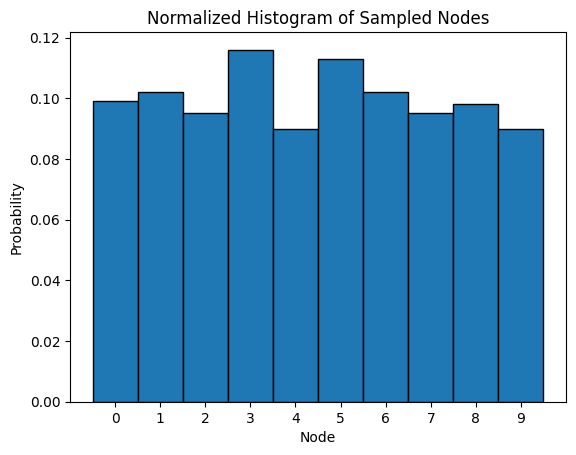

In [4]:
import matplotlib.pyplot as plt
# Example usage
samples = polymer.sample_distribution(num_samples=1000)

# Plot the normalized histogram
plt.hist(samples, bins=np.arange(polymer.num_nodes + 1) - 0.5, density=True, edgecolor='black')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.title('Normalized Histogram of Sampled Nodes')
plt.xticks(np.arange(polymer.num_nodes))
plt.show()

In [5]:
# Check normalization
if polymer.check_normalization():
    print("The probability distribution is normalized.")
else:
    print("The probability distribution is not normalized.")

The probability distribution is normalized.


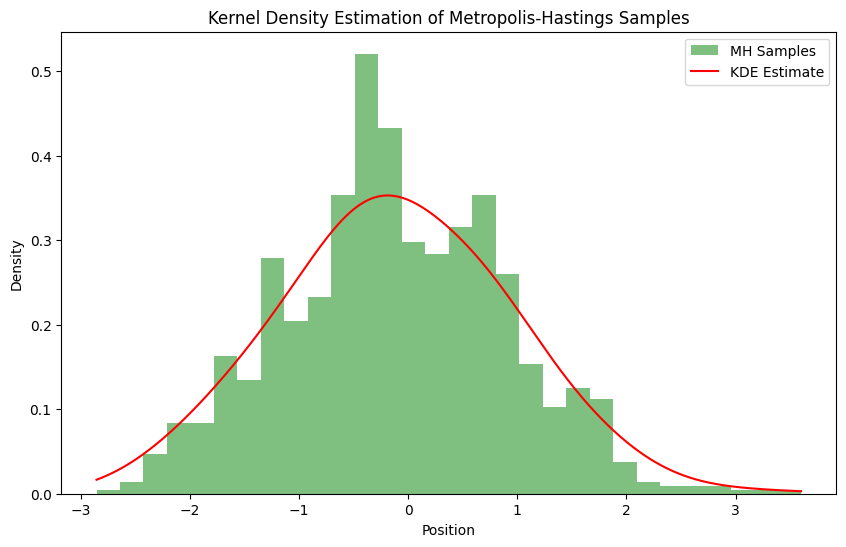

In [6]:
from sklearn.neighbors import KernelDensity


# Sample from the distribution using Metropolis-Hastings
proposal_std = 1.0 
initial_pos = polymer.positions[3]  # Start with the first node's position
mh_samples = polymer.metropolis_hastings(initial_pos, num_samples, proposal_std)

# Perform Kernel Density Estimation (KDE)
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(mh_samples[:, np.newaxis])
x_d = np.linspace(min(mh_samples), max(mh_samples), 1000)[:, np.newaxis]
log_dens = kde.score_samples(x_d)
dens = np.exp(log_dens)

# Plotting
plt.figure(figsize=(10, 6))

# Plot histogram of MH samples
plt.hist(mh_samples, bins=30, density=True, alpha=0.5, color='g', label='MH Samples')

# Plot KDE curve
plt.plot(x_d, dens, 'r-', label='KDE Estimate')

plt.title('Kernel Density Estimation of Metropolis-Hastings Samples')
plt.xlabel('Position')
plt.ylabel('Density')
plt.legend()
plt.show()

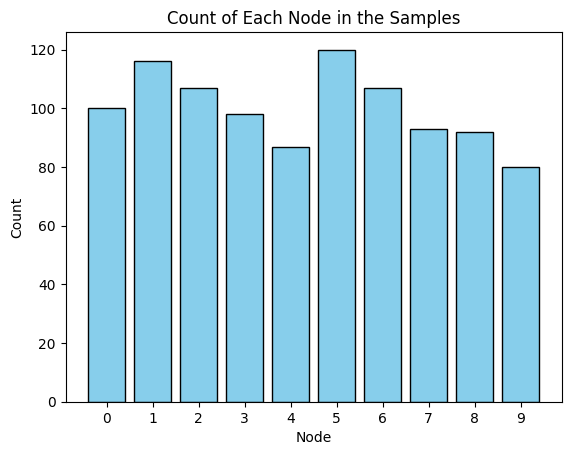

In [7]:
samples = polymer.sample_distribution(num_samples=num_samples)

# Count occurrences of each node
counts = np.bincount(samples, minlength=num_nodes)

# Plot the histogram of counts
plt.bar(np.arange(num_nodes), counts, color='skyblue', edgecolor='black')
plt.xlabel('Node')
plt.ylabel('Count')
plt.title('Count of Each Node in the Samples')
plt.xticks(np.arange(num_nodes))
plt.show()

In [8]:
def metropolis_hastings_node(node_index, initial_pos, num_samples, proposal_std, means, stds):
    samples = np.zeros(num_samples)
    samples[0] = initial_pos

    mean = means[node_index]
    std = stds[node_index]

    for i in range(1, num_samples):
        current_pos = samples[i - 1]
        proposed_pos = current_pos + np.random.normal(0, proposal_std)

        proposed_pos = np.clip(proposed_pos, -10, 10)

        current_prob = norm.pdf(current_pos, mean, std)
        proposed_prob = norm.pdf(proposed_pos, mean, std)
        
        acceptance_ratio = proposed_prob / current_prob
        acceptance_probability = min(1, acceptance_ratio)

        if np.random.rand() < acceptance_probability:
            samples[i] = proposed_pos
        else:
            samples[i] = current_pos

    return samples

def generate_multimodal_distribution_from_nodes(polymer, selected_nodes, num_samples_per_node, proposal_std):
    # Distinct means for each node to create multimodal distribution
    means = np.linspace(-5, 5, polymer.num_nodes)
    stds = np.ones(polymer.num_nodes)  # Same std deviation for simplicity
    all_samples = []
    
    for node_index in selected_nodes:
        initial_pos = means[node_index]
        node_samples = metropolis_hastings_node(node_index, initial_pos, num_samples_per_node, proposal_std, means, stds)
        all_samples.extend(node_samples)
    
    return np.array(all_samples)

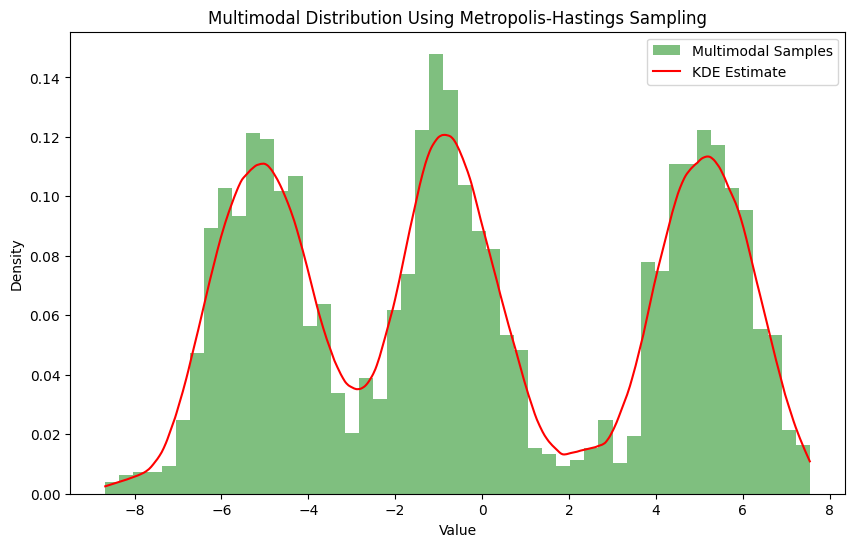

In [9]:
# Specify which nodes to sample from
selected_nodes = [0, 4, 9]  # Example nodes to pick
num_samples_per_node = 1000
proposal_std = 1.0

# Generate multimodal distribution
samples = generate_multimodal_distribution_from_nodes(polymer, selected_nodes, num_samples_per_node, proposal_std)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.5, color='g', label='Multimodal Samples')

# Plot KDE for visualizing the distribution
kde = KernelDensity(kernel='epanechnikov', bandwidth=1.0).fit(samples[:, np.newaxis])
x_d = np.linspace(min(samples), max(samples), 1000)[:, np.newaxis]
log_dens = kde.score_samples(x_d)
dens = np.exp(log_dens)
plt.plot(x_d, dens, 'r-', label='KDE Estimate')

plt.title('Multimodal Distribution Using Metropolis-Hastings Sampling')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [10]:
  # Convert log density to normal density
# Normalize check
from scipy.integrate import simps

integral = simps(dens, x_d[:, 0])
print(f'Integral of KDE density: {integral:.4f}')

Integral of KDE density: 0.9961


/var/folders/cf/3rb10wvd7l5bcg3nnk3w22000000gn/T/ipykernel_4978/370311831.py:5: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(dens, x_d[:, 0])
